<h1><center>Fashion_MNIST Dataset Introduction</center></h1>

### Contents
* [Introduction](#intro)
* [Setup](#second-bullet)
* [Fashion_MNIST](#dataset)
* [UMAP](#umap)
* [Machine Learning models:](#ml)  
[Random Forest](#ranfor)  
[Extra Tree](#extree)  
[XGBoost](#xgb)  
[Support Vector Machine](#svm)
* [Convolution Neural Network](#cnn)
* [Confusion Matrix](#conmat)
* [Binomial Error of Machine Learning Results](#error)
* [Run time comparison](#time)

### Introduction <a class="anchor" id="intro"></a>

Fashion-MNIST is a dataset of images from Zalando (https://www.zalando.co.uk/), a German fashion website. The dataset consists of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes (corresponding to an item of clothing). Fashion-MNIST is intended to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

Here's an example some of the images in the dataset. Each class (or clothing item) takes three-rows.

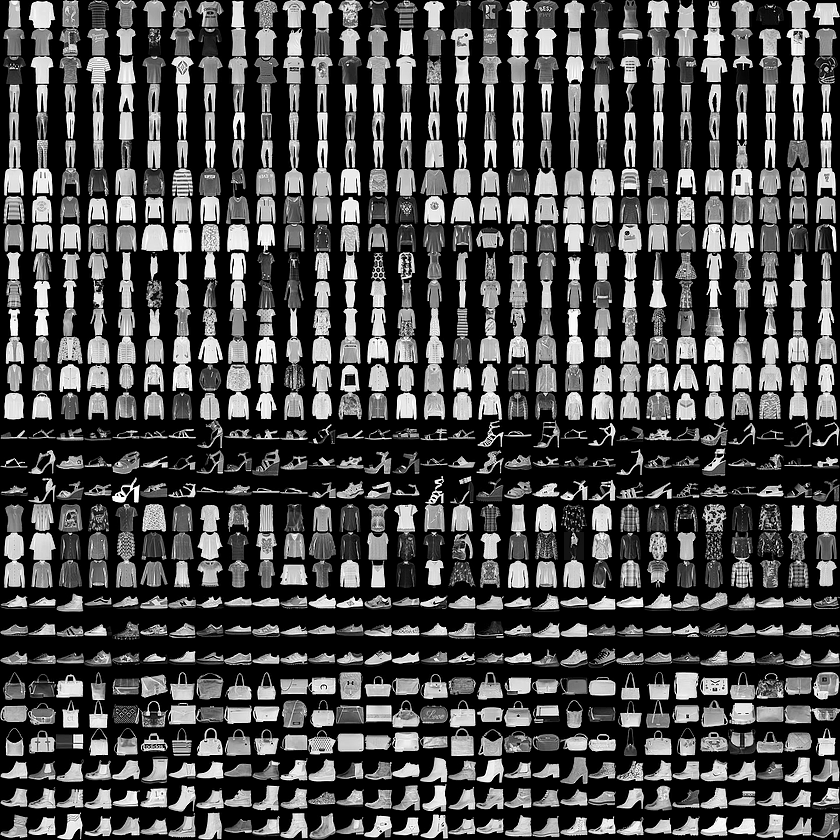

In [1]:
from IPython.display import Image
Image(filename='doc/img/fashion-mnist-sprite.png')

### Setup <a class="anchor" id="second-bullet"></a>
#### Python Imports

In [2]:
# Import libraries (alphabethical order now)
import importlib.util
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(0)
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as pyoff
import scipy.stats as stats
import seaborn as sns; sns.set()
import tensorflow as tf
import time
import umap
import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

from sklearn import svm
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.framework import ops
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

//anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning:

compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5



### Importing the Fashion_MNIST data <a class="anchor" id="dataset"></a>

In [4]:
# Import Fashion MNIST data with one-hot encoding.
dir_fashion = 'data/fashion/'
fashion_mnist = input_data.read_data_sets(dir_fashion, one_hot=True)

Extracting data/fashion/train-images-idx3-ubyte.gz
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz


In [5]:
# These are the labels attached to each image from the data set, 
# and the item of clothing which they correspond to.
label_dict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

Here are examples of 2 different images with their corresponding labels.

y = 3 (Dress)


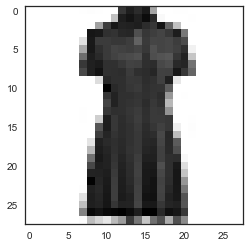

y = 0 (T-shirt/top)


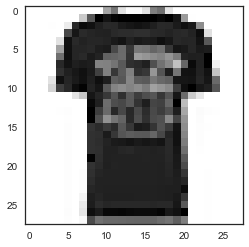

In [11]:
sns.set(style='white', rc={'figure.figsize':(6,4)})
# Get random images and associated label
sample_1 = fashion_mnist.train.images[47].reshape(28,28)
sample_label_1 = np.where(fashion_mnist.train.labels[47] == 1)[0][0]

# Show images and labels
print("y = {label_index} ({label})".format(label_index=sample_label_1, label=label_dict[sample_label_1]))
plt.imshow(sample_1, cmap='Greys')
plt.show()

sample_2 = fashion_mnist.train.images[200].reshape(28,28)
sample_label_2 = np.where(fashion_mnist.train.labels[200] == 1)[0][0]
print("y = {label_index} ({label})".format(label_index=sample_label_2, label=label_dict[sample_label_2]))
plt.imshow(sample_2, cmap='Greys')
plt.show()

Fashion_MNIST data is divided into train set and test set. At this point in the notebook we put the test data to one side and train our algorithms only on the training set.

In [6]:
train = fashion_mnist.train
test = fashion_mnist.test

### UMAP <a class="anchor" id="umap"></a>

After importing the datasets we can visualise it using a UMAP script. UMAP is a dimension reduction technique for data visualisation that is much faster than previously available techiniques. The Fashion MNIST embedded via UMAP shows the multidimensional space mapped into 2D with certain clusters closer or further apart. 

Visualise the train set only? Will this make a difference?

In [7]:
train_labels = []

for i in range (train.labels.shape[0]):
    classifier = np.where(fashion_mnist.train.labels[i] == 1)[0][0]
    train_labels.append(classifier)
test_labels= []
for i in range (test.labels.shape[0]):
    classifier = np.where(fashion_mnist.train.labels[i] == 1)[0][0]
    test_labels.append(classifier)

In [8]:
%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(12,8)})

data = np.array(np.vstack([train.images, test.images]), dtype=np.float64) / 255.0
target = np.array(np.hstack([train_labels, test_labels]))

In [9]:
%%time
embedding = umap.UMAP(n_neighbors=5, metric='euclidean', random_state=42).fit_transform(data)

CPU times: user 1min 6s, sys: 10.6 s, total: 1min 16s
Wall time: 56 s


In [10]:
v = list(np.arange(10))

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

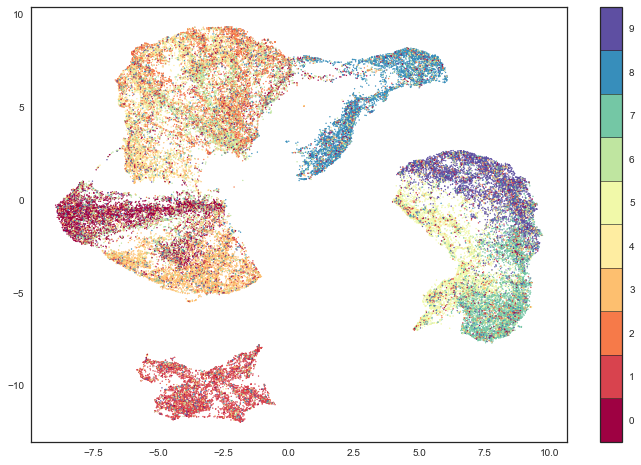

In [11]:
plt.scatter(embedding[:,0], embedding[:,1], c=target, cmap="Spectral", s=1)
#cbar = plt.colorbar(values=np.arange(10) , boundaries=np.arange(11)-0.5, ticks=np.arange(10), drawedges=True)
cbar = plt.colorbar(values=v, boundaries=np.arange(11)-0.5, ticks=np.arange(10), drawedges=True)
label_dict

### Comparison of Machine Learning Models <a class="anchor" id="ml"></a>

This classified training dataset can be trained through various machine learning models and compared according to their accuracy, running speed and binominal error bounds. 

In [12]:
# Load in the python file as a module.
my_file = 'utils/mnist_reader.py'
spec = importlib.util.spec_from_file_location("mnist_reader", my_file)
foo = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo)

In [13]:
# import utils.mnist_reader as foo

In [14]:
data_train = foo.load_mnist(dir_fashion, kind='train')
data_test = foo.load_mnist(dir_fashion, kind='t10k')

In [15]:
data_train_images = data_train[0] 
data_train_labels = data_train[1] 
data_test_images = data_test[0]
data_test_labels = data_test[1]

Initialise empty lists to store model names, accuracies and times. 

In [16]:
models = []
accuracies = []
times = []

### Random Forest <a class="anchor" id="ranfor"></a>

This Decision Tree classifier is trained using different random subsets of the training set. To make a prediction, you obtain the prediction of all individual trees, then predict the class that gets the most votes. It is one of the most powerful Machine Learning algorithms available based on the "the wisdom of the crowd".

In [17]:
start = time.time()

rnd_clf = RandomForestClassifier(n_estimators=100, max_depth=50, criterion='entropy')
rnd_clf.fit(data_train_images , data_train_labels)

end = time.time()
time_rf= (end - start)

print (time_rf)
models.append('Random Forest')
times.append(round(time_rf, 2))

93.391845703125


In [18]:
data_test_labels_predicted = rnd_clf.predict(data_test_images)
accu_rf = accuracy_score(data_test_labels_predicted, data_test_labels)
accuracies.append(accu_rf)

In [19]:
print(models, accuracies, times)

['Random Forest'] [0.8756] [93.39]


### Extra Tree <a class="anchor" id="extree"></a>

When growing a tree in a Random Forest at each node only a random subset of features is considered for splitting. It is possible to make trees even more random by using random tresholds for each feature rather than searching for the best possible threshold (this makes Extra Trees much faster).

In [20]:
start = time.time()

clf = ExtraTreesClassifier(n_estimators=50, max_depth=None, min_samples_split = 2, random_state=0)
clf.fit (data_train_images , data_train_labels)

end = time.time()
time_et=(end - start)

models.append('Extra Tree')
times.append(round (time_et, 2))

data_test_labels_predicted = clf.predict(data_test_images)
accu_et = accuracy_score(data_test_labels_predicted, data_test_labels)
accuracies.append(accu_et)

In [21]:
print(models, accuracies, times)

['Random Forest', 'Extra Tree'] [0.8756, 0.8731] [93.39, 24.5]


Alternatively use cross validation function on Extra Trees where a training set is split into smaller training set and validation set, then trained against smaller training set and evaluated against validation set.  

In [22]:
# # This code is commented out to avoid running the same
# # model twice with cross validation. If you want to use it just uncomment the code.

# #Extra Tree 
# start = time.time()

# clf = ExtraTreesClassifier(n_estimators=50, max_depth=None, min_samples_split = 2, random_state=0)
# scores = cross_val_score(clf, data_train_images , data_train_labels)
# acc_et = scores.mean()
# accuracies.append(acc_et)

# end = time.time()
# time_et=(end - start)

# models.append('Extra Tree')
# times.append(round (time_et, 2))

### XGBoost <a class="anchor" id="xgb"></a>

XGBoost uses gradient boosting to sequentially add new trees to an ensemble of trees, each one correcting its preceding tree. This method tries to fit the new decision tree to the residual errors made by the previous tree focusing on "hard" cases.

This model takes about 40 min to train. 

In [49]:
start = time.time()

model = XGBClassifier()
model.fit(data_train_images, data_train_labels)

end = time.time()
time_xgb=(end - start)

models.append('XGBoost')
times.append(round (time_xgb, 2))

In [75]:
# make predictions for test data
data_test_labels_predicted = model.predict(data_test_images)
predictions = [round(value) for value in data_test_labels_predicted]
# evaluate predictions
accuracy = accuracy_score(data_test_labels, data_test_labels_predicted)
accuracies.append(accuracy)

In [76]:
print(models, accuracies, times)

['Random Forest', 'Extra Tree', 'SVM', 'CNN model', 'XGBoost'] [0.8765, 0.8731, 0.8723, 0.888, 0.8582] [96.53, 24.56, 1111.21, 66.01, 2310.27]


### Support Vector Machine <a class="anchor" id="ranfor"></a>

Support Vector Machine can be thought of as fitting the widest possible street (represented by the parallel dashed lines) between the classes. SVM is particularly well suited for the classification of complex but small or medium sized datasets.

This takes about 20 min to run.

In [31]:
start = time.time()

# Create SVM classification object 
model = svm.SVC(kernel='poly', gamma=1) 
model.fit(data_train_images, data_train_labels)
model.score(data_train_images, data_train_labels)

end = time.time()
time_svm=(end - start)

models.append('SVM')
times.append(round (time_svm, 2))

In [32]:
#Predict Output
data_test_labels_predicted = model.predict(data_test_images)
accuracy = accuracy_score(data_test_labels, data_test_labels_predicted)
accuracies.append(accuracy)

In [34]:
print(models, accuracies, times)

['Random Forest', 'Extra Tree', 'SVM'] [0.8765, 0.8731, 0.8723] [96.53, 24.56, 1111.21]


Dropped Gradient Boosting Classifier - results were poor and running time high. 

### Convolutional Neural Networks <a class="anchor" id="cnn"></a>

In the Convolutional Neural Networks the most important building block is the convolutional layer: neurons in the first convolutional layer are not connected to every single pixel in the image, but only to pixels in the receptive fileds. The architecture allows the network to concentrate on the low-level features in the first hidden layer, then assemble them into higher-level features in the next one. 

The CNN model is in a separate notebook as it has to be built from basic layers, ReLU and pooling. http://localhost:8889/notebooks/Documents/GitHub/fashion-mnist-nn/CNN%20model.ipynb#

Below we add the values from the CNN model in the notebook referenced above.

In [23]:
models.append('CNN model')
times.append(66.01)
accuracies.append(0.888)

In [24]:
print(models, accuracies, times)

['Random Forest', 'Extra Tree', 'CNN model'] [0.8756, 0.8731, 0.888] [93.39, 24.5, 66.01]


In [25]:
data_for_pretty_display = [item for item in zip(models, accuracies, times)]
pd.DataFrame(data_for_pretty_display, columns = ['Model','Accuracy','Time Taken (secs)'])

Model  Accuracy  Time Taken (secs)
0  Random Forest    0.8756              93.39
1     Extra Tree    0.8731              24.50
2      CNN model    0.8880              66.01

### Confusion Matrix <a class="anchor" id="conmat"></a>

The confusion matrix - each row represents an actual class while the column represents a predicted class. Some examples of what this shows are as follows:
- 834 t-shirts were correctly identified as t-shirts.
- 4 t-shirts were incorrectly identified as trouser.
- 5 trouser were incorrectly identified as t-shirts.

In [26]:
matrix = confusion_matrix(data_test_labels, data_test_labels_predicted)

Rows are actual labels and columns are identfied labels


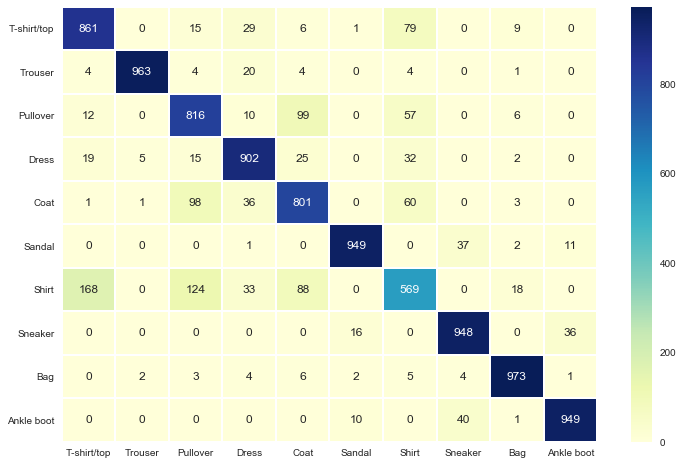

In [29]:
print ('Rows are actual labels and columns are identfied labels')
ax = sns.heatmap(matrix, cmap="YlGnBu", linewidths=1.0, annot=True, fmt="d", 
                 xticklabels= label_dict.values(),
                 yticklabels= label_dict.values())

### Binomial Error of Machine Learning Results<a class="anchor" id="error"></a>

In the theory of probability and statistics, a Bernoulli trial (or binomial trial) is a random experiment with exactly two possible outcomes, "success" and "failure", in which the probability of success is the same every time the experiment is conducted. The Binomial error provides us with a confidence interval of the probability we calculate, which indicates how much lower or higher it can be.

In [30]:
pyoff.offline.init_notebook_mode()

In [31]:
def binomial_error(n, p):
    # This returns the standard deviation on the quantity p.
    # The arguments are in the order n first, p second,
    # to be consistent with scipy.stats.binom
    return np.sqrt((p*(1-p)/n))

In [32]:
binomial_error(10000, 0.8837)

0.0032058432588010282

In [33]:
def chart_by_segments_binominal_error(segments, n_throws_by_segment, n_wins_by_segment, 
                                      my_title, percent=True):

    percent_by_segment = [a/b for a, b in zip(n_wins_by_segment, n_throws_by_segment)]
    error_by_segment = [binomial_error(b, c) for b, c in zip(n_throws_by_segment, percent_by_segment)]
    my_text = [str(a)+' / '+str(b) for a, b in zip(n_wins_by_segment, n_throws_by_segment)]
    
    if(percent):
        percent_by_segment = [100*a for a in percent_by_segment]
        #percent_by_segment = ["{:.2%}".format(a) for a in percent_by_segment]
        error_by_segment = [100*a for a in error_by_segment]
    
    data = [
        go.Bar(
            x=segments,
            y=percent_by_segment,
            error_y=dict(
                array=error_by_segment,
                visible=True
            ),
            text = my_text
        )
    ]
    
    layout = go.Layout(
        title = my_title,
        yaxis = dict(title='Accuracies (%)')
    )
    
    fig = go.Figure(data=data, layout=layout)
    pyoff.iplot(fig, filename='percent-error-bar') 

In [34]:
print(models, accuracies, times)

['Random Forest', 'Extra Tree', 'CNN model'] [0.8756, 0.8731, 0.888] [93.39, 24.5, 66.01]


In [35]:
number_of_test_images=len(data_test_images)
n_wins_by_segment = [y *number_of_test_images for y in accuracies]
print (n_wins_by_segment)

[8756.0, 8731.0, 8880.0]


In [36]:
n_throws_by_segment = [number_of_test_images]*len(accuracies)
chart_by_segments_binominal_error(models, n_throws_by_segment, n_wins_by_segment, my_title='Models Accuarcy Comparison')

### Run time comparison <a class="anchor" id="time"></a>

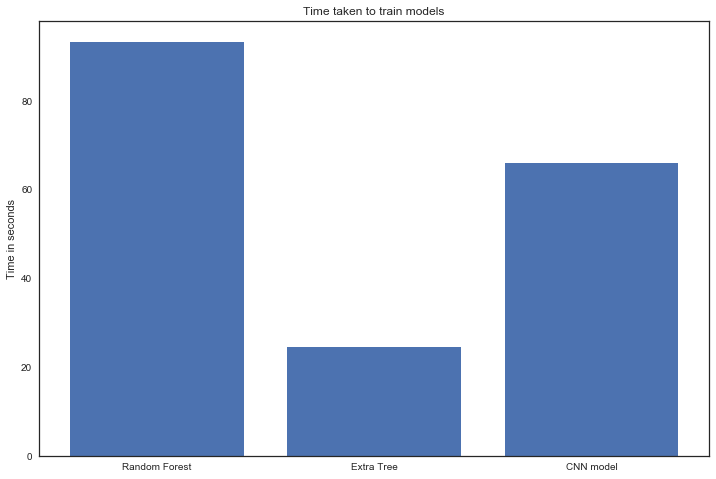

In [37]:
x = np.arange((len(times)))
plt.bar(x, times)
plt.title('Time taken to train models')
plt.ylabel('Time in seconds')
plt.xticks(x, models);